# Import Required Libraries

In [6]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

In [7]:
import os
import json
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
    precision_recall_fscore_support, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize


def plotting(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", marker="o", linestyle="-", color="blue")
    plt.plot(history["val_loss"], label="Validation Loss", marker="s", linestyle="-", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", marker="o", linestyle="-", color="green")
    plt.plot(history["val_acc"], label="Validation Accuracy", marker="s", linestyle="-", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_model(model, dataloader, class_names=dataset.classes, top_k=(1, 5), loader_name="Validation", model_name="Model"):
    print(f"\n========== Evaluating {model_name} on {loader_name} Set ==========\n")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                top_k_correct[k] += np.sum(labels.cpu().numpy()[:, None] == top_k_preds[:, :k])
            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }


def save_model_artifacts(
    model,
    history,
    metrics,
    model_name="model",
    version="V1",
    base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"
):
    """
    Saves model, training metrics, and evaluation metrics in a structured format.

    Args:
        model (torch.nn.Module): Trained model to save.
        history (dict): Training history with 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
        metrics (dict): Evaluation metrics dictionary.
        model_name (str): Name of the model (e.g., "deit_small", "mobilevit", etc.).
        version (str): Version identifier (e.g., "V1", "V2").
        base_dir (str): Base directory to save all artifacts.
    """
    # Save training metrics
    logs_dir = os.path.join(base_dir, "RESULTS~", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"{model_name}_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    # Save model
    model_dir = os.path.join(base_dir, "MODELS~", model_name)
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"{model_name}_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save evaluation metrics
    eval_dir = os.path.join(base_dir, "RESULTS~", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"{model_name}_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    # Save class-wise metrics
    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"{model_name}_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")

# Define Dataset Path and Transformations

In [8]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the Dataset

In [9]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


# Splitting the Dataset into Training and Validation Sets 85-15

In [10]:
from torch.utils.data import random_split, DataLoader

total_size = len(dataset)

train_size = round(0.70 * total_size)
val_size = round(0.20 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3430
Validation samples: 980
Test samples: 490


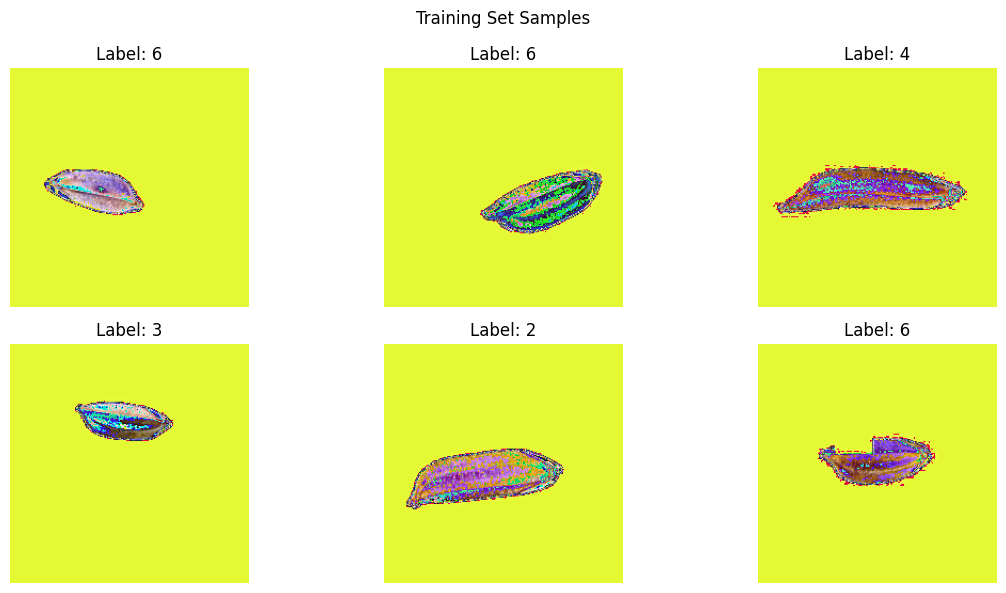

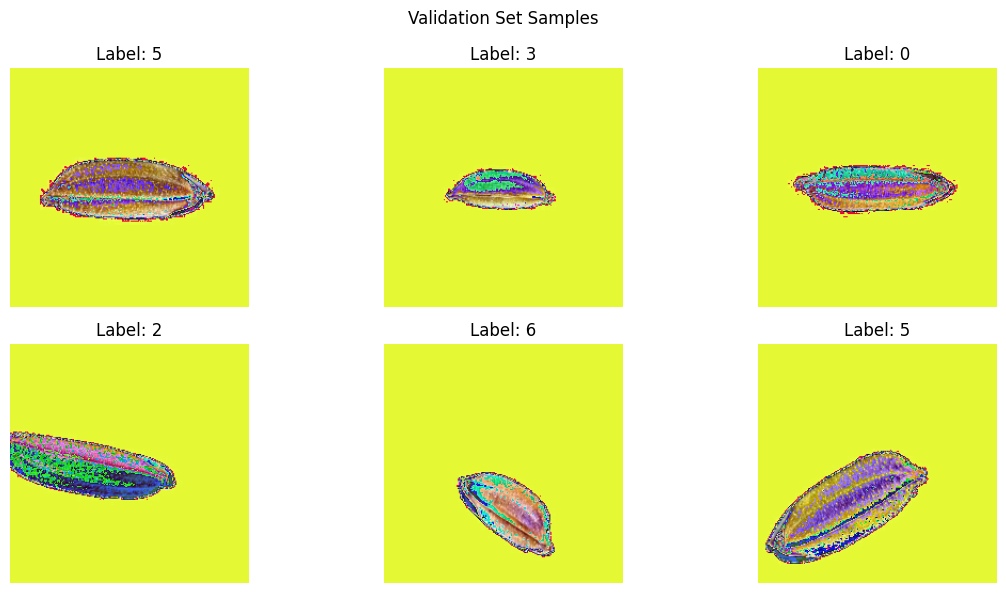

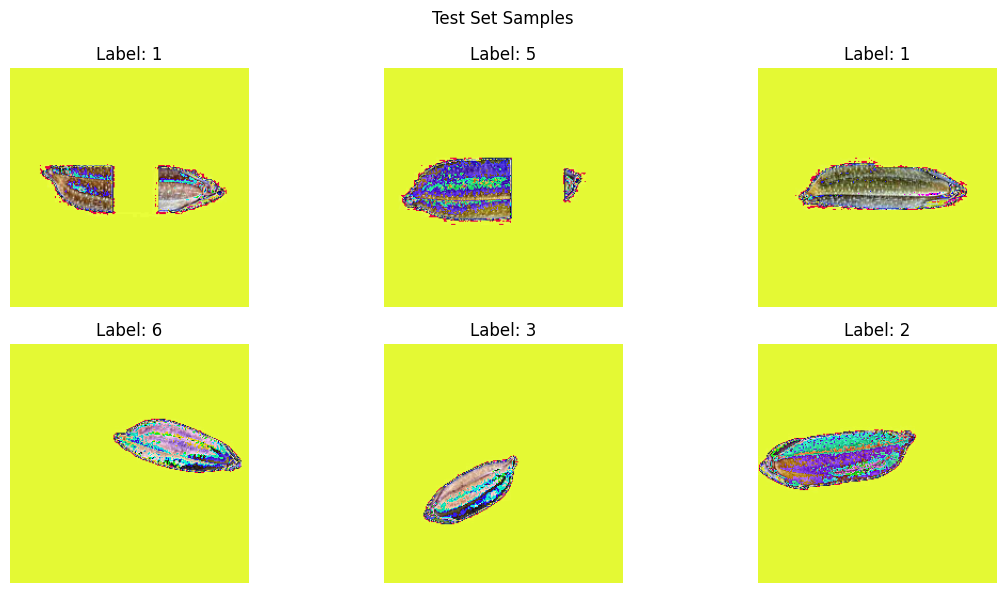

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_images_from_loader(data_loader, title, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = F.to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images_from_loader(train_loader, "Training Set Samples")
show_images_from_loader(val_loader, "Validation Set Samples")
show_images_from_loader(test_loader, "Test Set Samples")

# Loading the Swin-Tiny Model

In [12]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

# Load pretrained Swin-Tiny with appropriate output classes
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.patch_embed.parameters():
    param.requires_grad = True

for param in model.head.parameters():
    param.requires_grad = True

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded and moved to {device}")
print("Only patch embedding (input) and classification head (output) are trainable.")

Model loaded and moved to cpu
Only patch embedding (input) and classification head (output) are trainable.


# Defining Loss Function and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

# Defining the Training Loop

In [14]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "swin_tiny_best_model.pth")
            print("Model improved. Best checkpoint saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history
history1 = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=40, patience=40)

Epoch 1/40: 100%|███████████████████████████████| 54/54 [20:20<00:00, 22.61s/it]


Epoch 1/40: Train Loss: 1.5258, Train Acc: 48.28% | Val Loss: 1.0405, Val Acc: 76.63%
Model improved. Best checkpoint saved.


Epoch 2/40: 100%|███████████████████████████████| 54/54 [21:19<00:00, 23.69s/it]


Epoch 2/40: Train Loss: 0.9528, Train Acc: 74.02% | Val Loss: 0.7540, Val Acc: 76.43%
Model improved. Best checkpoint saved.


Epoch 3/40: 100%|███████████████████████████████| 54/54 [21:11<00:00, 23.55s/it]


Epoch 3/40: Train Loss: 0.7608, Train Acc: 77.08% | Val Loss: 0.6505, Val Acc: 80.20%
Model improved. Best checkpoint saved.


Epoch 4/40: 100%|███████████████████████████████| 54/54 [25:06<00:00, 27.90s/it]


Epoch 4/40: Train Loss: 0.5991, Train Acc: 82.83% | Val Loss: 0.4740, Val Acc: 87.24%
Model improved. Best checkpoint saved.


Epoch 5/40: 100%|███████████████████████████████| 54/54 [28:57<00:00, 32.18s/it]


Epoch 5/40: Train Loss: 0.5240, Train Acc: 84.55% | Val Loss: 0.4071, Val Acc: 87.24%
Model improved. Best checkpoint saved.


Epoch 6/40: 100%|███████████████████████████████| 54/54 [27:28<00:00, 30.53s/it]


Epoch 6/40: Train Loss: 0.4846, Train Acc: 85.31% | Val Loss: 0.3895, Val Acc: 88.37%
Model improved. Best checkpoint saved.


Epoch 7/40: 100%|███████████████████████████████| 54/54 [25:08<00:00, 27.93s/it]


Epoch 7/40: Train Loss: 0.4379, Train Acc: 86.91% | Val Loss: 0.3637, Val Acc: 88.06%
Model improved. Best checkpoint saved.


Epoch 8/40: 100%|███████████████████████████████| 54/54 [25:27<00:00, 28.28s/it]


Epoch 8/40: Train Loss: 0.4142, Train Acc: 87.20% | Val Loss: 0.3678, Val Acc: 89.29%
No improvement. Early stopping counter: 1/40


Epoch 9/40: 100%|███████████████████████████████| 54/54 [25:32<00:00, 28.38s/it]


Epoch 9/40: Train Loss: 0.3814, Train Acc: 88.48% | Val Loss: 0.3252, Val Acc: 89.18%
Model improved. Best checkpoint saved.


Epoch 10/40: 100%|██████████████████████████████| 54/54 [22:16<00:00, 24.76s/it]


Epoch 10/40: Train Loss: 0.3516, Train Acc: 89.15% | Val Loss: 0.2748, Val Acc: 91.63%
Model improved. Best checkpoint saved.


Epoch 11/40: 100%|██████████████████████████████| 54/54 [21:00<00:00, 23.34s/it]


Epoch 11/40: Train Loss: 0.3293, Train Acc: 90.23% | Val Loss: 0.2985, Val Acc: 90.00%
No improvement. Early stopping counter: 1/40


Epoch 12/40: 100%|██████████████████████████████| 54/54 [22:20<00:00, 24.83s/it]


Epoch 12/40: Train Loss: 0.3301, Train Acc: 90.26% | Val Loss: 0.2666, Val Acc: 91.12%
Model improved. Best checkpoint saved.


Epoch 13/40: 100%|██████████████████████████████| 54/54 [17:52<00:00, 19.87s/it]


Epoch 13/40: Train Loss: 0.3043, Train Acc: 90.70% | Val Loss: 0.2452, Val Acc: 91.53%
Model improved. Best checkpoint saved.


Epoch 14/40: 100%|██████████████████████████████| 54/54 [19:19<00:00, 21.48s/it]


Epoch 14/40: Train Loss: 0.2975, Train Acc: 90.61% | Val Loss: 0.2526, Val Acc: 91.53%
No improvement. Early stopping counter: 1/40


Epoch 15/40: 100%|██████████████████████████████| 54/54 [19:08<00:00, 21.26s/it]


Epoch 15/40: Train Loss: 0.2822, Train Acc: 91.66% | Val Loss: 0.2545, Val Acc: 91.84%
No improvement. Early stopping counter: 2/40


Epoch 16/40: 100%|██████████████████████████████| 54/54 [18:39<00:00, 20.73s/it]


Epoch 16/40: Train Loss: 0.2717, Train Acc: 91.92% | Val Loss: 0.2431, Val Acc: 91.73%
Model improved. Best checkpoint saved.


Epoch 17/40: 100%|██████████████████████████████| 54/54 [19:24<00:00, 21.57s/it]


Epoch 17/40: Train Loss: 0.2546, Train Acc: 92.33% | Val Loss: 0.2291, Val Acc: 92.86%
Model improved. Best checkpoint saved.


Epoch 18/40: 100%|██████████████████████████████| 54/54 [18:24<00:00, 20.46s/it]


Epoch 18/40: Train Loss: 0.2327, Train Acc: 93.32% | Val Loss: 0.2211, Val Acc: 92.55%
Model improved. Best checkpoint saved.


Epoch 19/40: 100%|██████████████████████████████| 54/54 [22:47<00:00, 25.32s/it]


Epoch 19/40: Train Loss: 0.2242, Train Acc: 93.94% | Val Loss: 0.2138, Val Acc: 92.96%
Model improved. Best checkpoint saved.


Epoch 20/40: 100%|██████████████████████████████| 54/54 [16:47<00:00, 18.66s/it]


Epoch 20/40: Train Loss: 0.2294, Train Acc: 93.06% | Val Loss: 0.2107, Val Acc: 93.37%
Model improved. Best checkpoint saved.


Epoch 21/40: 100%|██████████████████████████████| 54/54 [09:48<00:00, 10.90s/it]


Epoch 21/40: Train Loss: 0.2240, Train Acc: 92.83% | Val Loss: 0.2291, Val Acc: 92.76%
No improvement. Early stopping counter: 1/40


Epoch 22/40: 100%|██████████████████████████████| 54/54 [09:37<00:00, 10.70s/it]


Epoch 22/40: Train Loss: 0.2011, Train Acc: 94.43% | Val Loss: 0.2010, Val Acc: 93.27%
Model improved. Best checkpoint saved.


Epoch 23/40: 100%|██████████████████████████████| 54/54 [09:50<00:00, 10.94s/it]


Epoch 23/40: Train Loss: 0.2061, Train Acc: 93.79% | Val Loss: 0.2252, Val Acc: 92.96%
No improvement. Early stopping counter: 1/40


Epoch 24/40: 100%|██████████████████████████████| 54/54 [09:58<00:00, 11.08s/it]


Epoch 24/40: Train Loss: 0.2109, Train Acc: 93.82% | Val Loss: 0.2209, Val Acc: 93.98%
No improvement. Early stopping counter: 2/40


Epoch 25/40: 100%|██████████████████████████████| 54/54 [09:51<00:00, 10.96s/it]


Epoch 25/40: Train Loss: 0.2093, Train Acc: 93.53% | Val Loss: 0.2054, Val Acc: 93.06%
No improvement. Early stopping counter: 3/40


Epoch 26/40: 100%|██████████████████████████████| 54/54 [15:09<00:00, 16.83s/it]


Epoch 26/40: Train Loss: 0.2006, Train Acc: 93.82% | Val Loss: 0.1955, Val Acc: 94.18%
Model improved. Best checkpoint saved.


Epoch 27/40: 100%|██████████████████████████████| 54/54 [22:21<00:00, 24.84s/it]


Epoch 27/40: Train Loss: 0.1849, Train Acc: 94.90% | Val Loss: 0.1841, Val Acc: 93.98%
Model improved. Best checkpoint saved.


Epoch 28/40: 100%|██████████████████████████████| 54/54 [22:01<00:00, 24.47s/it]


Epoch 28/40: Train Loss: 0.1892, Train Acc: 94.69% | Val Loss: 0.1857, Val Acc: 94.29%
No improvement. Early stopping counter: 1/40


Epoch 29/40: 100%|██████████████████████████████| 54/54 [21:38<00:00, 24.04s/it]


Epoch 29/40: Train Loss: 0.1918, Train Acc: 94.29% | Val Loss: 0.1904, Val Acc: 93.88%
No improvement. Early stopping counter: 2/40


Epoch 30/40: 100%|██████████████████████████████| 54/54 [20:51<00:00, 23.18s/it]


Epoch 30/40: Train Loss: 0.1767, Train Acc: 94.96% | Val Loss: 0.1834, Val Acc: 94.18%
Model improved. Best checkpoint saved.


Epoch 31/40: 100%|██████████████████████████████| 54/54 [23:35<00:00, 26.21s/it]


Epoch 31/40: Train Loss: 0.1761, Train Acc: 95.04% | Val Loss: 0.1857, Val Acc: 94.18%
No improvement. Early stopping counter: 1/40


Epoch 32/40: 100%|██████████████████████████████| 54/54 [24:03<00:00, 26.73s/it]


Epoch 32/40: Train Loss: 0.1802, Train Acc: 95.10% | Val Loss: 0.1805, Val Acc: 94.18%
Model improved. Best checkpoint saved.


Epoch 33/40: 100%|██████████████████████████████| 54/54 [22:55<00:00, 25.47s/it]


Epoch 33/40: Train Loss: 0.1680, Train Acc: 95.28% | Val Loss: 0.1816, Val Acc: 94.49%
No improvement. Early stopping counter: 1/40


Epoch 34/40: 100%|██████████████████████████████| 54/54 [24:18<00:00, 27.01s/it]


Epoch 34/40: Train Loss: 0.1684, Train Acc: 95.48% | Val Loss: 0.1769, Val Acc: 94.59%
Model improved. Best checkpoint saved.


Epoch 35/40: 100%|██████████████████████████████| 54/54 [20:48<00:00, 23.13s/it]


Epoch 35/40: Train Loss: 0.1611, Train Acc: 95.89% | Val Loss: 0.1764, Val Acc: 94.39%
Model improved. Best checkpoint saved.


Epoch 36/40: 100%|██████████████████████████████| 54/54 [20:27<00:00, 22.74s/it]


Epoch 36/40: Train Loss: 0.1698, Train Acc: 95.16% | Val Loss: 0.1774, Val Acc: 94.39%
No improvement. Early stopping counter: 1/40


Epoch 37/40: 100%|██████████████████████████████| 54/54 [11:37<00:00, 12.92s/it]


Epoch 37/40: Train Loss: 0.1659, Train Acc: 95.57% | Val Loss: 0.1766, Val Acc: 94.69%
No improvement. Early stopping counter: 2/40


Epoch 38/40: 100%|██████████████████████████████| 54/54 [08:14<00:00,  9.16s/it]


Epoch 38/40: Train Loss: 0.1632, Train Acc: 95.74% | Val Loss: 0.1755, Val Acc: 94.49%
Model improved. Best checkpoint saved.


Epoch 39/40: 100%|██████████████████████████████| 54/54 [08:03<00:00,  8.96s/it]


Epoch 39/40: Train Loss: 0.1696, Train Acc: 95.39% | Val Loss: 0.1758, Val Acc: 94.49%
No improvement. Early stopping counter: 1/40


Epoch 40/40: 100%|██████████████████████████████| 54/54 [08:02<00:00,  8.93s/it]


Epoch 40/40: Train Loss: 0.1612, Train Acc: 95.54% | Val Loss: 0.1756, Val Acc: 94.49%
No improvement. Early stopping counter: 2/40


# Visualizing Training & Validation Performance

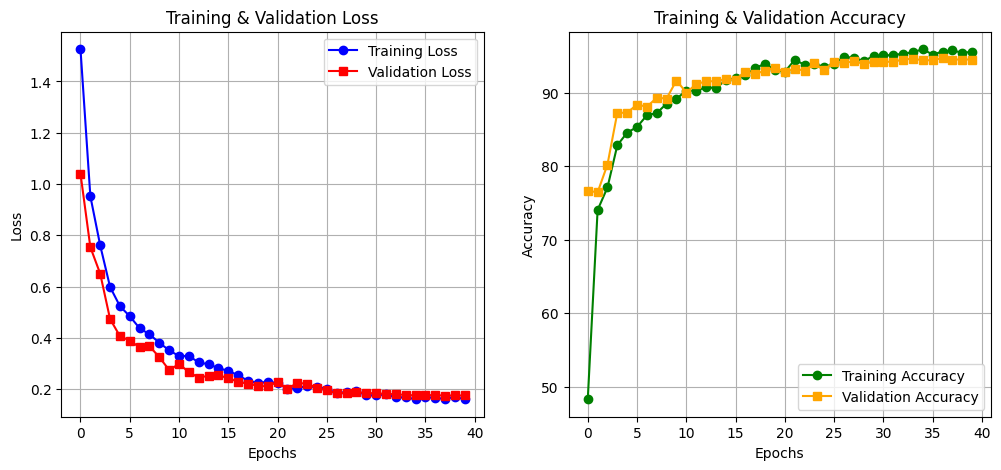


========== Evaluating Swin-tiny V1 on Validation Set ==========


Overall Accuracy: 94.49%
Overall Error Rate: 5.51%
F1-Score (Macro-Averaged): 94.44%
F1-Score (Weighted): 94.47%
Matthews Correlation Coefficient (MCC): 93.57%
Cohen’s Kappa Score: 93.57%
Top-1 Accuracy (%): 94.49%
Top-5 Accuracy (%): 99.90%

Average Inference Time per Image: 0.068130 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          88.73       87.50         88.11            98.09
 BRRI_28          96.92       94.74         95.82            99.53
 BRRI_29          90.98       88.32         89.63            98.58
 BRRI_34          96.95       96.21         96.58            99.53
 BRRI_50          92.86       97.74         95.24            98.82
 BRRI_74          96.97       98.77         97.86            99.39
    BR_5          97.84       97.84         97.84            99.64

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108 

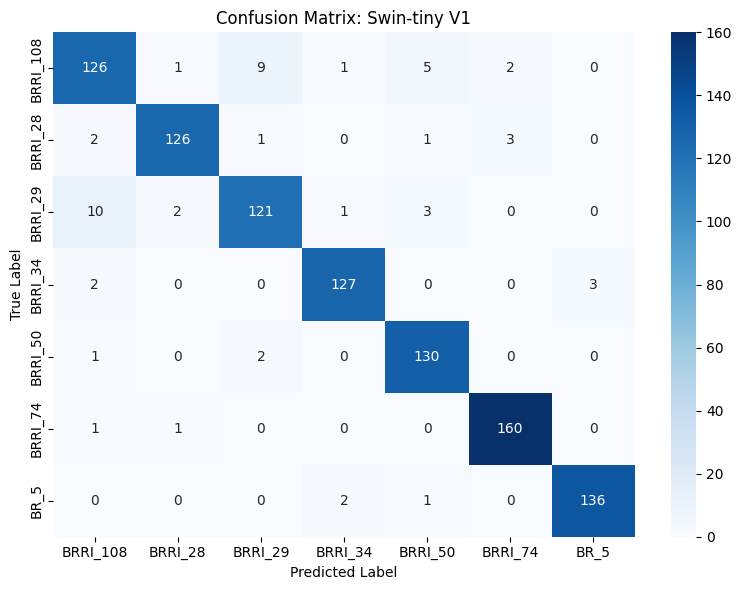

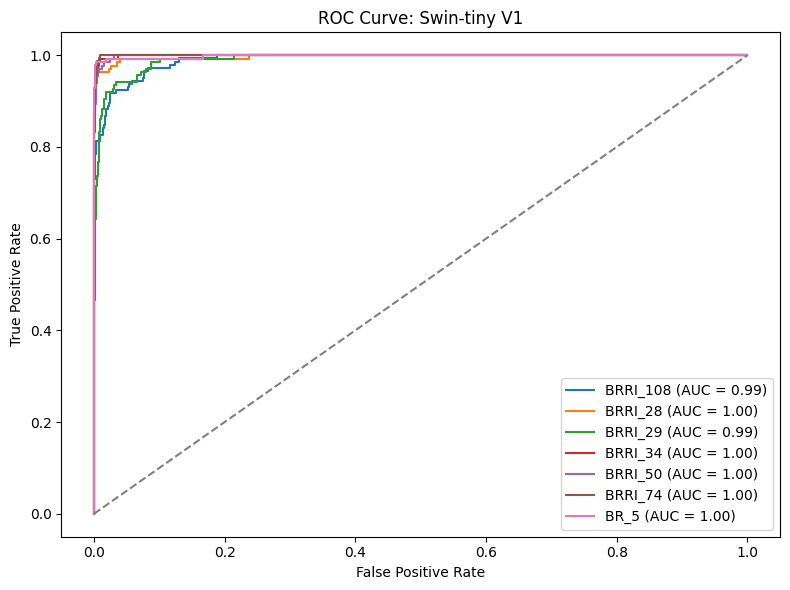

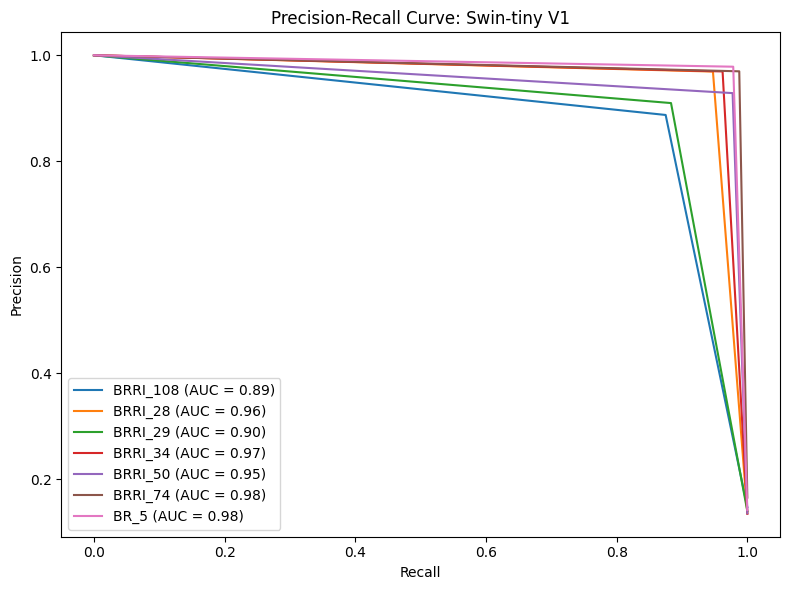


========== Evaluating Swin-tiny V1 on Tesing Set ==========


Overall Accuracy: 96.12%
Overall Error Rate: 3.88%
F1-Score (Macro-Averaged): 96.19%
F1-Score (Weighted): 96.12%
Matthews Correlation Coefficient (MCC): 95.49%
Cohen’s Kappa Score: 95.47%
Top-1 Accuracy (%): 96.12%
Top-5 Accuracy (%): 99.80%

Average Inference Time per Image: 0.067676 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          98.51       89.19         93.62            99.76
 BRRI_28          95.59      100.00         97.74            99.29
 BRRI_29          89.61       94.52         92.00            98.08
 BRRI_34          97.06       95.65         96.35            99.52
 BRRI_50          95.89       98.59         97.22            99.28
 BRRI_74         100.00       96.72         98.33           100.00
    BR_5          97.44       98.70         98.06            99.52

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108     

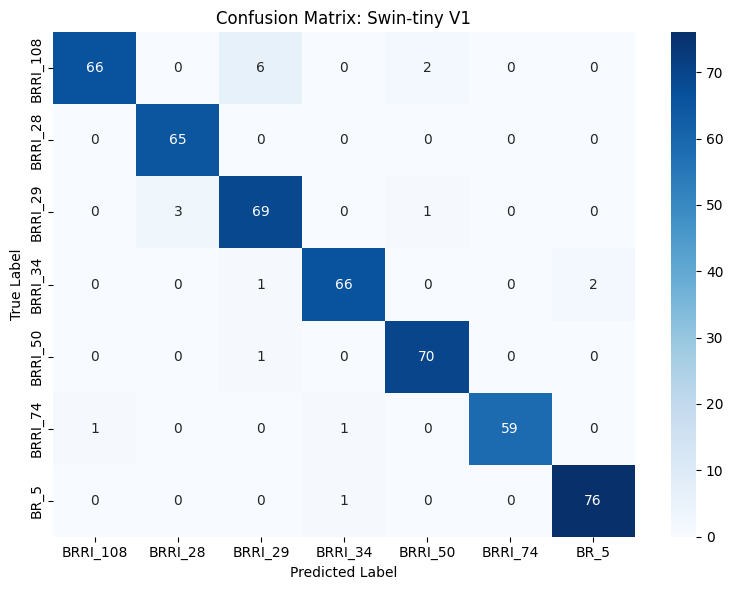

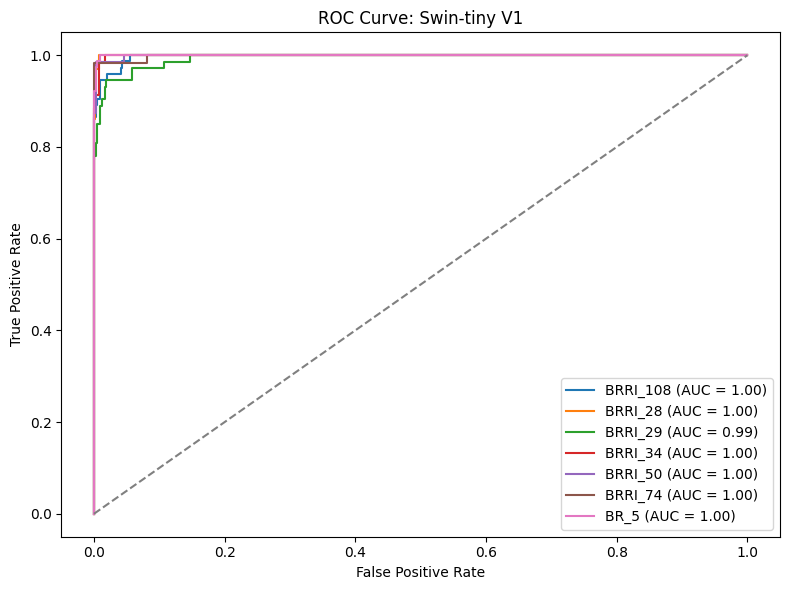

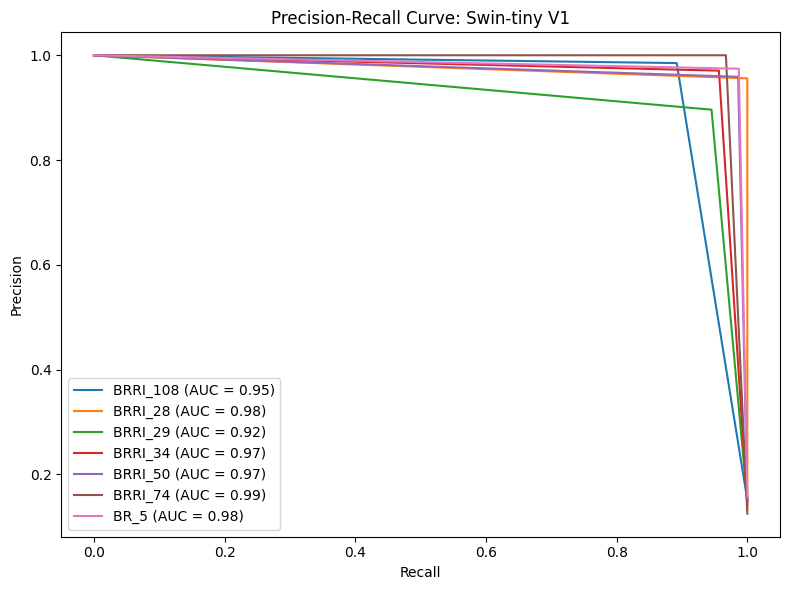

In [20]:
plotting(history1)
metrics1 = evaluate_model(model, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="Swin-tiny V1")
metrics1 = evaluate_model(model, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="Swin-tiny V1")

In [21]:
save_model_artifacts(model=model,history=history1,metrics=metrics1,model_name="Swin_tiny_Final",version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS~/logs/Swin_tiny_Final_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS~/Swin_tiny_Final/Swin_tiny_Final_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS~/evaluation_logs/Swin_tiny_Final_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS~/evaluation_logs/Swin_tiny_Final_class_wise_metrics_1.csv


# Half of the layers unfrozen

In [22]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS~/Swin_tiny_Final/Swin_tiny_Final_1.pth"
model3 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=7)
model3.load_state_dict(torch.load(model_path, map_location='cpu'))

# Freeze all parameters
for param in model3.parameters():
    param.requires_grad = False

# Unfreeze patch_embed and head
for param in model3.patch_embed.parameters():
    param.requires_grad = True
for param in model3.head.parameters():
    param.requires_grad = True

# Unfreeze all blocks in Stage 0 (2 blocks)
for param in model3.layers[0].parameters():
    param.requires_grad = True

# Unfreeze last 2 blocks of Stage 2 (total 6 blocks)
for block in model3.layers[2].blocks[4:]:
    for param in block.parameters():
        param.requires_grad = True

# Unfreeze all blocks in Stage 3 (2 blocks)
for param in model3.layers[3].parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW([
    {'params': model3.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model3.layers.parameters(), 'lr': 3e-5},
    {'params': model3.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

In [23]:
history2 = train(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=20,
    patience=20
)

Epoch 1/20: 100%|███████████████████████████████| 54/54 [14:52<00:00, 16.52s/it]


Epoch 1/20: Train Loss: 0.1568, Train Acc: 94.78% | Val Loss: 0.1553, Val Acc: 95.00%
Model improved. Best checkpoint saved.


Epoch 2/20: 100%|███████████████████████████████| 54/54 [15:08<00:00, 16.82s/it]


Epoch 2/20: Train Loss: 0.0851, Train Acc: 96.94% | Val Loss: 0.1163, Val Acc: 96.84%
Model improved. Best checkpoint saved.


Epoch 3/20: 100%|███████████████████████████████| 54/54 [13:04<00:00, 14.53s/it]


Epoch 3/20: Train Loss: 0.0469, Train Acc: 98.54% | Val Loss: 0.0983, Val Acc: 96.63%
Model improved. Best checkpoint saved.


Epoch 4/20: 100%|███████████████████████████████| 54/54 [12:34<00:00, 13.96s/it]


Epoch 4/20: Train Loss: 0.0457, Train Acc: 98.54% | Val Loss: 0.1063, Val Acc: 96.63%
No improvement. Early stopping counter: 1/20


Epoch 5/20: 100%|███████████████████████████████| 54/54 [12:42<00:00, 14.12s/it]


Epoch 5/20: Train Loss: 0.0412, Train Acc: 98.60% | Val Loss: 0.1157, Val Acc: 96.12%
No improvement. Early stopping counter: 2/20


Epoch 6/20: 100%|███████████████████████████████| 54/54 [12:35<00:00, 13.99s/it]


Epoch 6/20: Train Loss: 0.0291, Train Acc: 99.04% | Val Loss: 0.0895, Val Acc: 97.35%
Model improved. Best checkpoint saved.


Epoch 7/20: 100%|███████████████████████████████| 54/54 [12:36<00:00, 14.02s/it]


Epoch 7/20: Train Loss: 0.0255, Train Acc: 99.21% | Val Loss: 0.0887, Val Acc: 97.14%
Model improved. Best checkpoint saved.


Epoch 8/20: 100%|███████████████████████████████| 54/54 [13:09<00:00, 14.62s/it]


Epoch 8/20: Train Loss: 0.0176, Train Acc: 99.59% | Val Loss: 0.0914, Val Acc: 97.55%
No improvement. Early stopping counter: 1/20


Epoch 9/20: 100%|███████████████████████████████| 54/54 [13:08<00:00, 14.60s/it]


Epoch 9/20: Train Loss: 0.0165, Train Acc: 99.56% | Val Loss: 0.0759, Val Acc: 97.96%
Model improved. Best checkpoint saved.


Epoch 10/20: 100%|██████████████████████████████| 54/54 [13:06<00:00, 14.57s/it]


Epoch 10/20: Train Loss: 0.0173, Train Acc: 99.42% | Val Loss: 0.0901, Val Acc: 97.65%
No improvement. Early stopping counter: 1/20


Epoch 11/20: 100%|██████████████████████████████| 54/54 [16:06<00:00, 17.90s/it]


Epoch 11/20: Train Loss: 0.0169, Train Acc: 99.56% | Val Loss: 0.0743, Val Acc: 97.86%
Model improved. Best checkpoint saved.


Epoch 12/20: 100%|██████████████████████████████| 54/54 [17:22<00:00, 19.31s/it]


Epoch 12/20: Train Loss: 0.0158, Train Acc: 99.48% | Val Loss: 0.0764, Val Acc: 97.86%
No improvement. Early stopping counter: 1/20


Epoch 13/20: 100%|██████████████████████████████| 54/54 [12:45<00:00, 14.17s/it]


Epoch 13/20: Train Loss: 0.0138, Train Acc: 99.65% | Val Loss: 0.0744, Val Acc: 97.76%
No improvement. Early stopping counter: 2/20


Epoch 14/20: 100%|██████████████████████████████| 54/54 [13:13<00:00, 14.70s/it]


Epoch 14/20: Train Loss: 0.0115, Train Acc: 99.74% | Val Loss: 0.0664, Val Acc: 98.16%
Model improved. Best checkpoint saved.


Epoch 15/20: 100%|██████████████████████████████| 54/54 [13:09<00:00, 14.61s/it]


Epoch 15/20: Train Loss: 0.0111, Train Acc: 99.77% | Val Loss: 0.0660, Val Acc: 98.06%
Model improved. Best checkpoint saved.


Epoch 16/20: 100%|██████████████████████████████| 54/54 [13:21<00:00, 14.85s/it]


Epoch 16/20: Train Loss: 0.0136, Train Acc: 99.74% | Val Loss: 0.0687, Val Acc: 97.96%
No improvement. Early stopping counter: 1/20


Epoch 17/20: 100%|██████████████████████████████| 54/54 [13:20<00:00, 14.82s/it]


Epoch 17/20: Train Loss: 0.0080, Train Acc: 99.83% | Val Loss: 0.0627, Val Acc: 98.27%
Model improved. Best checkpoint saved.


Epoch 18/20: 100%|██████████████████████████████| 54/54 [13:43<00:00, 15.26s/it]


Epoch 18/20: Train Loss: 0.0067, Train Acc: 99.85% | Val Loss: 0.0628, Val Acc: 98.16%
No improvement. Early stopping counter: 1/20


Epoch 19/20: 100%|██████████████████████████████| 54/54 [12:41<00:00, 14.09s/it]


Epoch 19/20: Train Loss: 0.0074, Train Acc: 99.80% | Val Loss: 0.0619, Val Acc: 98.16%
Model improved. Best checkpoint saved.


Epoch 20/20: 100%|██████████████████████████████| 54/54 [13:11<00:00, 14.66s/it]


Epoch 20/20: Train Loss: 0.0091, Train Acc: 99.77% | Val Loss: 0.0619, Val Acc: 98.16%
No improvement. Early stopping counter: 1/20


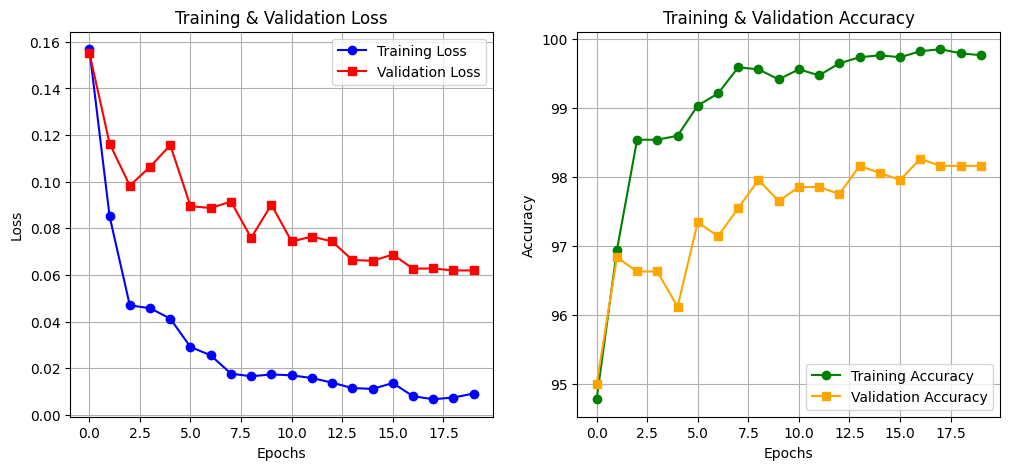


========== Evaluating Swin-tiny V3 on Validation Set ==========


Overall Accuracy: 98.16%
Overall Error Rate: 1.84%
F1-Score (Macro-Averaged): 98.14%
F1-Score (Weighted): 98.16%
Matthews Correlation Coefficient (MCC): 97.86%
Cohen’s Kappa Score: 97.86%
Top-1 Accuracy (%): 98.16%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.062087 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          97.87       95.83         96.84            99.64
 BRRI_28          98.48       97.74         98.11            99.76
 BRRI_29          95.65       96.35         96.00            99.29
 BRRI_34          97.04       99.24         98.13            99.53
 BRRI_50          99.25      100.00         99.63            99.88
 BRRI_74          99.38       99.38         99.38            99.88
    BR_5          99.28       98.56         98.92            99.88

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108

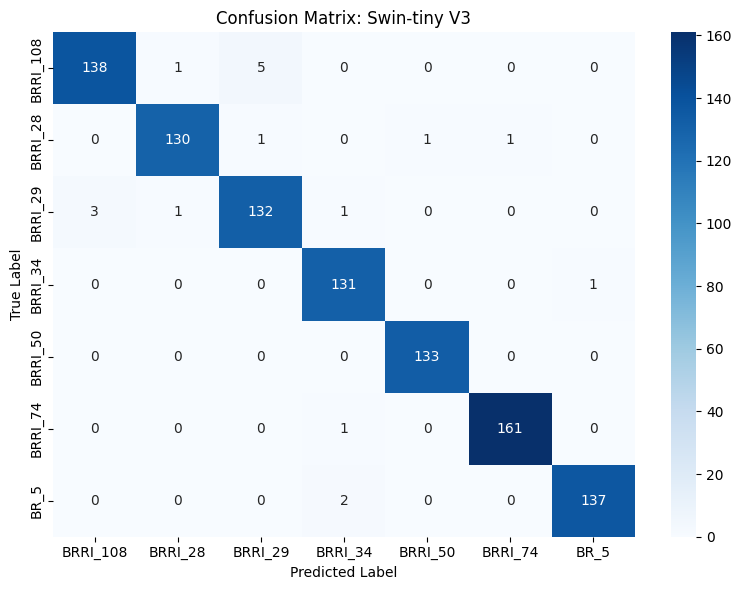

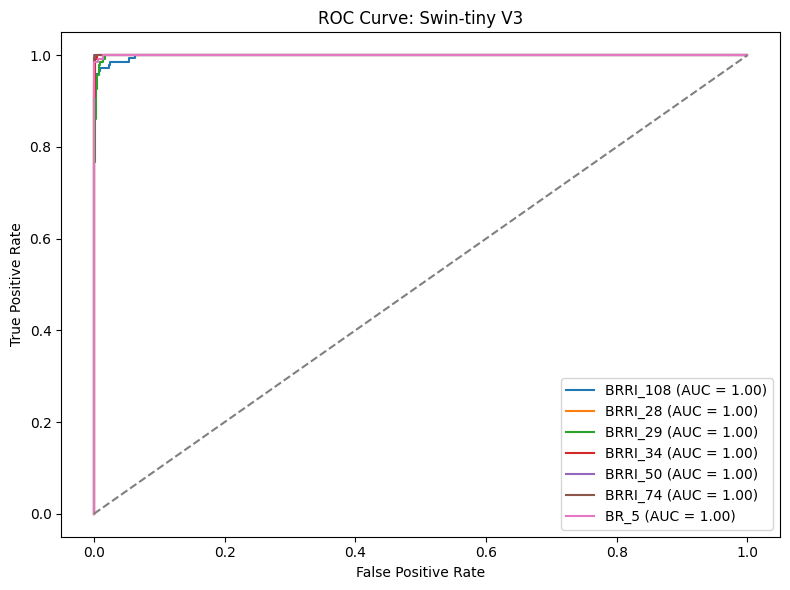

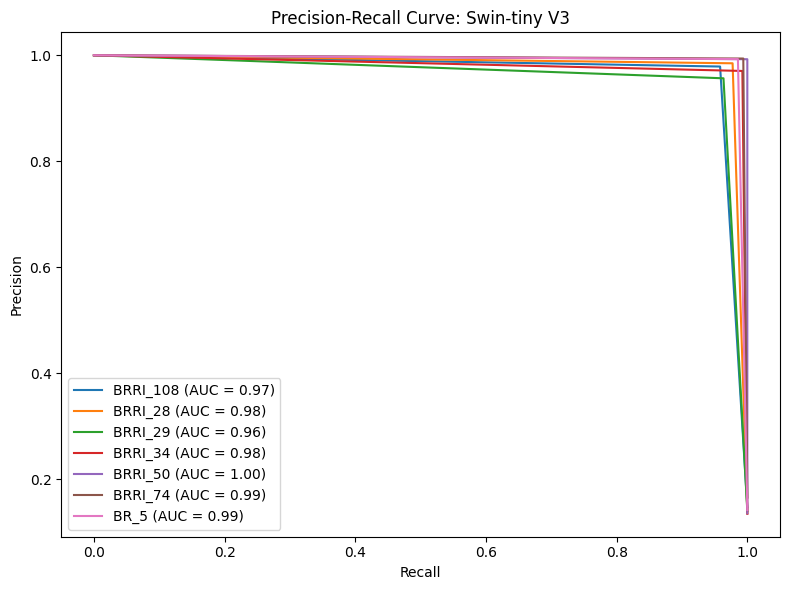


========== Evaluating Swin-tiny V3 on Tesing Set ==========


Overall Accuracy: 97.55%
Overall Error Rate: 2.45%
F1-Score (Macro-Averaged): 97.61%
F1-Score (Weighted): 97.55%
Matthews Correlation Coefficient (MCC): 97.14%
Cohen’s Kappa Score: 97.14%
Top-1 Accuracy (%): 97.55%
Top-5 Accuracy (%): 99.80%

Average Inference Time per Image: 0.062515 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          97.30       97.30         97.30            99.52
 BRRI_28         100.00       98.46         99.22           100.00
 BRRI_29          94.67       97.26         95.95            99.04
 BRRI_34          98.48       94.20         96.30            99.76
 BRRI_50          97.22       98.59         97.90            99.52
 BRRI_74         100.00       98.36         99.17           100.00
    BR_5          96.20       98.70         97.44            99.27

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108     

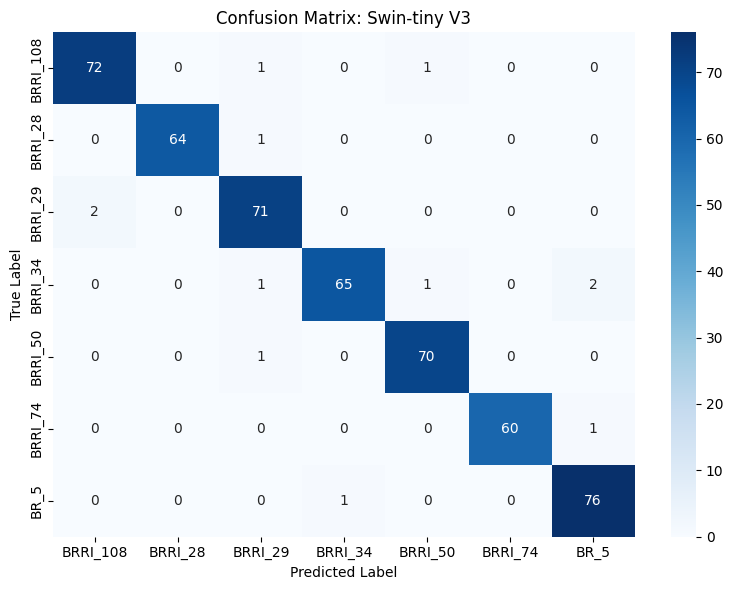

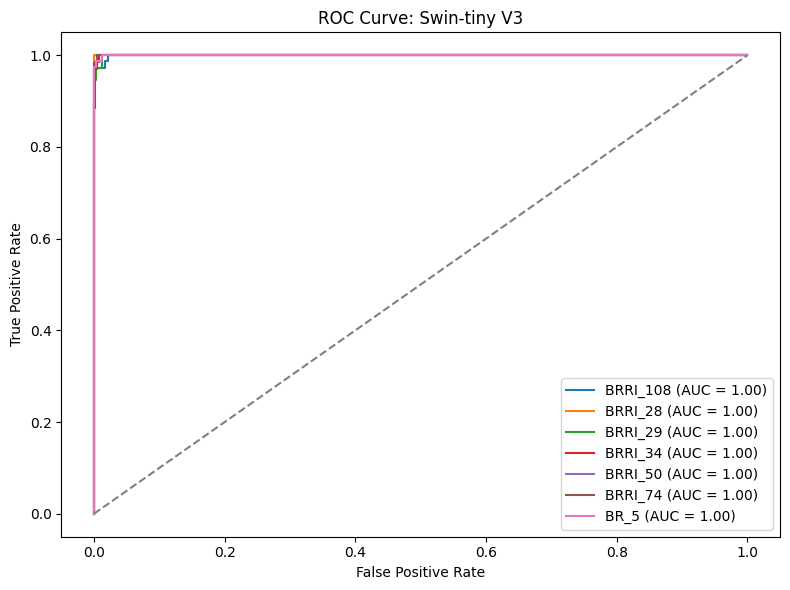

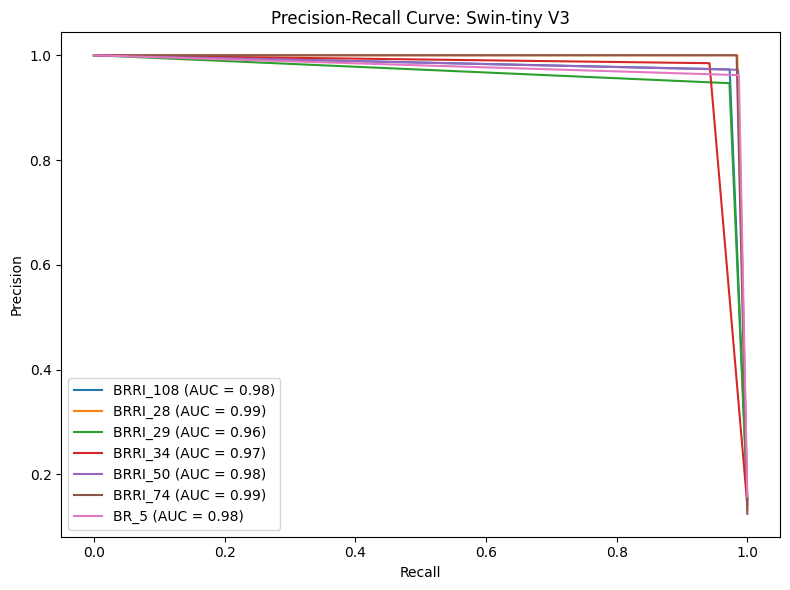

In [24]:
plotting(history2)
metrics2 = evaluate_model(model3, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="Swin-tiny V3")
metrics2 = evaluate_model(model3, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="Swin-tiny V3")